In [1]:
#notebooks to create UMAP figures
#first few steps get the lesional features, plotting UMAPs happens further down

In [1]:
from meld_classifier.paths import BASE_PATH, EXPERIMENT_PATH
from meld_classifier.experiment import Experiment
from meld_classifier.meld_cohort import MeldCohort, MeldSubject
from meld_classifier.dataset import load_combined_hemisphere_data, Dataset
from meld_classifier.training import Trainer
from meld_classifier.evaluation import Evaluator
import os
import json
import glob
import h5py
import numpy as np
# import logging
# # set logging to debug to see all messages (set to INFO in real scripts)
# logging.basicConfig(level=logging.FATAL)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib import gridspec

Setting MELD_DATA_PATH to /rds/user/kw350/rds-kw350-meld/meld_data/Data/
Setting BASE_PATH to /rds/user/kw350/rds-kw350-meld/meld_data/Data/
Setting EXPERIMENT_PATH to /rds/user/kw350/rds-kw350-meld/experiments/kw350/


In [2]:
c = MeldCohort(hdf5_file_root='{site_code}_{group}_featurematrix_combat_6.hdf5',
               dataset='MELD_dataset_V6.csv')

In [3]:
ids=c.get_subject_ids()

KeyboardInterrupt: 

In [ ]:
df = pd.DataFrame() 

hemis = ['left','right']
subjects = np.unique(ids)

#boundaries file
experiment_path='/rds/project/kw350/rds-kw350-meld/experiments/co-ripa1/iteration_21-09-15/ensemble_21-09-15/fold_all/'
bound_file=os.path.join(experiment_path,'results','test_results.csv')
df_bound=pd.read_csv(bound_file, header=0, encoding='unicode_escape')
df_bound = df_bound.dropna()

folder  = '/rds/project/kw350/rds-kw350-meld/experiments/co-ripa1/iteration_21-09-17/ensemble_21-09-20/fold_all/'
bound_file2=os.path.join(folder,'results','test_results.csv')
df_bound2=pd.read_csv(bound_file2, header=0, encoding='unicode_escape')
df_bound2 = df_bound2.dropna()
df_bound=df_bound.append(df_bound2)
df_bound.drop_duplicates(inplace=True,ignore_index=True)

#df_bound.drop_duplicates(inplace=True,ignore_index=False)
df_bound.index=df_bound.ID

In [ ]:
len(df_bound)

In [ ]:
patients=[]
controls=[]
for subject in np.unique(subjects):
    if 'FCD' in subject:
        patients.append(subject)
    else:
        controls.append(subject)

In [ ]:
def load_prediction(subject,hdf5):
    results={}
    with h5py.File(hdf5, "r") as f:
        for hemi in ['lh','rh']:
            results[hemi] = f[subject][hemi]['prediction'][:]
    return results

In [8]:
experiment_name='ensemble_0'
# hdf_predictions = os.path.join('/rds/project/kw350/rds-kw350-meld/experiments/kw350/iteration_21-05-26/ensemble_21-05-31/fold_all/','results','predictions_ensemble_iteration.hdf5')
# with h5py.File(hdf_predictions, "r") as f:
#     subjects=list(f.keys())

In [9]:
import meld_classifier.mesh_tools as mt
import meld_classifier.paths as paths

surf = mt.load_mesh_geometry(os.path.join(paths.BASE_PATH,'fsaverage_sym','surf','lh.inflated'))

In [241]:
#subjects=np.unique(df_bound['ID'])
#missing patients
#np.setdiff1d(subjects,df_bound['ID'])
folder

'/rds/project/kw350/rds-kw350-meld/experiments/co-ripa1/iteration_21-09-10/ensemble_21-09-10/fold_all/results/'

In [11]:
df=pd.DataFrame()
for subject in df_bound['ID']:
        subj = MeldSubject(subject,cohort=c)
        if 'FCD' in subject:
            group = 'patient'
            pair_subject=subject
        else:
            group = 'control'
            pair_subject = np.random.choice(patients)
            print(subject + ' pair with ' + pair_subject)
            patients.remove(pair_subject)
        #split hemi
        try:
            hdf_predictions = os.path.join(experiment_path,
                                           'results','predictions_ensemble_iteration.hdf5')
            result_hemis = load_prediction(subject,hdf_predictions)
        except KeyError:
            hdf_predictions = os.path.join(folder,
                                           'results','predictions_ensemble_iteration.hdf5')
            result_hemis = load_prediction(subject,hdf_predictions)
        features=subj.get_feature_list()
        labels_hemis = {}
        features_hemis={}
        for hemi in ['lh','rh']:
            features_hemis[hemi], labels_hemis[hemi] = subj.load_feature_lesion_data(
                features, hemi=hemi, features_to_ignore=[]
            )
        if group=='control':
            pair_subj = MeldSubject(pair_subject,cohort=c)
            for hemi in ['lh','rh']:
            
                _, labels_hemis[hemi] = pair_subj.load_feature_lesion_data(
                    features, hemi=hemi, features_to_ignore=[]
                )
        boundaries = df_bound.loc[subject, 'border']
        hemis=['lh','rh']
        #find cluster per hemispheres
        for hemi in hemis:
            clusters_i = list(set(result_hemis[hemi]))
            clusters_i.remove(0)
            clusters_i.append(666)
            for i in clusters_i:
                #get mask
                if i == 666:
                    if labels_hemis[hemi].any()==1:
                        mask = (labels_hemis[hemi]==1)[c.cortex_mask]
                        if group == 'control':
                            type_mask='lesion_pair'
                        else : 
                            type_mask='lesion'
                    else:
                        mask=None
                else :
                    mask = (result_hemis[hemi]==i)
                    type_mask='cluster'
                #categorize in : 2:borderzone 1:detected 0:FP
                if mask is not None:
                    values={}
                    values['ID']=subject
                    values['group'] = group
                    values['hemi'] = hemi
                    values['cluster_i']= i   
                    values['type_mask'] = type_mask
                    d=labels_hemis[hemi][c.cortex_mask]
                    if d[mask].sum()>=1:
                        values['detected']=1
                        values['size_detect']=d[mask].sum()
                    else:
                        values['detected']=0
                        values['size_detect']=0
                    if boundaries > 0 :
                        values['detected']=2
                        values['size_detect']=boundaries
                    values['size']= len(result_hemis[hemi][mask])
                    values['prediction']= np.mean(result_hemis[hemi][mask])
                    #extract features characteristics per clusters 
                    values['FLAIR']=False
                    for f,feature in enumerate(features):
                        if 'FLAIR' in feature: 
                            values['FLAIR']=True
                        feat = features_hemis[hemi][:,f][c.cortex_mask]
                        feat_clust = feat[mask]
                        values[feature] = np.mean(feat_clust)
                    #extract mean coordinates per clusters
                    values['x'] = surf['coords'][c.cortex_mask,0][mask].mean()
                    values['y'] = surf['coords'][c.cortex_mask,1][mask].mean()
                    values['z'] = surf['coords'][c.cortex_mask,2][mask].mean()
                    #add information in data frame
                    df2 = pd.DataFrame([values])   
                    df = df.append(df2,ignore_index=True)
    


MELD_H4_15T_C_0001 pair with MELD_H21_15T_FCD_0021
MELD_H3_3T_C_0081 pair with MELD_H16_3T_FCD_021
MELD_H3_3T_C_0068 pair with MELD_H17_15T_FCD_0009
MELD_H3_3T_C_0003 pair with MELD_H16_3T_FCD_016


KeyboardInterrupt: 

In [ ]:
# define if lesions are detected, borderline detected or not
for subject in np.unique(df['ID']):
#     print(subject)
    subsubdf=df[df['ID']==subject]
    lesion_i = subsubdf.index[subsubdf['type_mask'] == 'lesion'].tolist()
#     print('lesion = \n {} '.format(lesion_i))
    detectClust_1 = subsubdf.index[(subsubdf['group'] == 'patient') & (subsubdf['type_mask'] == 'cluster') & (subsubdf['detected'] ==1)].tolist()
    detectClust_2 = subsubdf.index[(subsubdf['group'] == 'patient') & (subsubdf['type_mask'] == 'cluster') & (subsubdf['detected'] ==2)].tolist()
#     print('clusters 1= \n {} '.format(detectClust_1))
#     print('clusters 2 = \n {} '.format(detectClust_2))
    if (lesion_i!=[]) & (detectClust_1!=[]):
#         df.set_value(lesion_i[0], 'detected',1)
        df.loc[lesion_i[0], 'detected'] = 1
    elif (lesion_i!=[]) & (detectClust_2!=[]):
        df.loc[lesion_i[0], 'detected'] = 2
    elif (lesion_i!=[]) & (detectClust_1==[]) & (detectClust_2==[]) :
        df.loc[lesion_i[0], 'detected'] = 0
    else:
        pass

In [ ]:
# add FLAIR info
flair_value= np.array(df['.inter_z.asym.intra_z.combat.on_lh.gm_FLAIR_0.25.sm10.mgh'])
flair = [ True if x!=0 else False for x in flair_value ]
df['FLAIR'] = flair

In [ ]:
# add histology
fcd_type=[]
demographics_file = '/home/kw350/rds/rds-kw350-meld/meld_data/Data/demographics_qc_allgroups.csv'

demographics = pd.read_csv(demographics_file, index_col=False)

for subject in df['ID']:
    fcd_type.append(demographics['Histology'][demographics['ID']==subject].values[0]) 
df['FCD_type']=fcd_type


In [ ]:
file = os.path.join('/home/kw350/rds/rds-kw350-meld/experiments/kw350',
                    'cluster_and_lesions_normalised.csv')
df.to_csv(file, index=False)


In [4]:
file = os.path.join('/home/kw350/rds/rds-kw350-meld/experiments/kw350',
                    'cluster_and_lesions_normalised.csv')
#file = '/rds/project/kw350/rds-kw350-meld/experiments/co-ripa1/cluster_and_lesions_umap_with0.csv'
df= pd.read_csv(file,header=0,encoding='unicode_escape')


In [5]:
outcomes=[]
demographics_file = '/home/kw350/rds/rds-kw350-meld/meld_data/Data/demographics_qc_allgroups.csv'

demographics = pd.read_csv(demographics_file, index_col=False)
mri_neg = []
for s in df.ID:
    outcomes.append(demographics['Seizure free'][demographics.ID==s].values[0])
    mri_neg.append(demographics['Ever reported MRI negative'][demographics.ID==s].values[0])
df['sf']=outcomes
df['mri_neg']=mri_neg

In [6]:
df['FCD_type'].values

array([nan, nan, nan, ..., 'FCD_2B', 'FCD_2B', nan], dtype=object)

In [7]:
histo=[]
for h in df['FCD_type']:
    if isinstance(h,str):
#         if 'FCD_2' in h:
#             histo.append("FCD_2")
#         else:
        histo.append(' '.join(h.split('_')))
    else:
        histo.append('Not operated\nNot available')
df['FCD_type']=histo

In [8]:
#df['FCD_type']

In [9]:
import itertools

from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl
import ptitprince as pt

from sklearn import mixture
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
import umap
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler


In [10]:
def mscatter(x,y,ax=None,label=None, m=None, s=20 ,**kw):
    import matplotlib.markers as mmarkers
    if not ax: ax=plt.gca()
    sc = ax.scatter(x,y,**kw, s=s,label=label)
    if (m is not None) and (len(m)==len(x)):
        paths = []
        for marker in m:
            if isinstance(marker, mmarkers.MarkerStyle):
                marker_obj = marker
            else:
                marker_obj = mmarkers.MarkerStyle(marker)
            path = marker_obj.get_path().transformed(
                        marker_obj.get_transform())
            paths.append(path)
        sc.set_paths(paths)
    #ax.set_xlim([-5,12.5])
    #ax.set_ylim([0,15])
    #plt.axis('off')
    return sc

def connectpoints(x,y,p1,p2):
    x1, x2 = x[p1], x[p2]
    y1, y2 = y[p1], y[p2]
    plt.plot([x1,x2],[y1,y2],'k-', linewidth=0.5)

    
def get_connection(df, detection=1 ,from_clust=None, reduce=False):
    connects=[]
    for subject in np.unique(df['ID']):
#         print(subject)
        subsubdf=df[df['ID']==subject]
    
        # get all the lesion from patients
        if from_clust is not None:
            lesion_i = subsubdf.index[(subsubdf['type_mask'] == 'lesion') & (subsubdf['detected'] == detection) & (subsubdf['out_class']==from_clust)].tolist()
        else:
            lesion_i = subsubdf.index[(subsubdf['type_mask'] == 'lesion') & (subsubdf['detected'] == detection)].tolist()
#         print('lesion = \n {} '.format(lesion_i))

        # get all the clusters
        detectClust_i = subsubdf.index[(subsubdf['group'] == 'patient') & (subsubdf['type_mask'] == 'cluster') 
                                       & (subsubdf['detected'] == detection)].tolist()
#         print('clusters = \n {} '.format(detectClust_i))
            
        if reduce==True:
            # connect only the cluster overlapping the most with the lesion
            size_detect = np.array(subsubdf[(subsubdf['group'] == 'patient') & (subsubdf['type_mask'] == 'cluster') 
                                           & (subsubdf['detected'] ==detection)]['size_detect'])
            sort_size=np.argsort(size_detect)[::-1]
            if (lesion_i!=[]) & (detectClust_i!=[]):
                main_cluster = np.array(detectClust_i)[sort_size][0]
                connects.append([lesion_i[0],main_cluster])
        else:  
#         connect all the clusters
            if lesion_i!=[]:
                for i in detectClust_i:
                    connects.append([lesion_i[0],i])
    return connects



In [11]:
analysis ='T1FLAIR' # T1w or T1FLAIR

if analysis=='T1': 
    keys = [
     '.inter_z.intra_z.combat.on_lh.pial.K_filtered.sm20.mgh',
     '.inter_z.intra_z.combat.on_lh.thickness.sm10.mgh',
     '.inter_z.intra_z.combat.on_lh.w-g.pct.sm10.mgh',
    '.combat.on_lh.sulc.sm5.mgh',
    ]
    
elif analysis=='T1FLAIR' : 
    keys = [
     
     '.inter_z.intra_z.combat.on_lh.pial.K_filtered.sm20.mgh',
     '.inter_z.intra_z.combat.on_lh.thickness.sm10.mgh',
     '.inter_z.intra_z.combat.on_lh.w-g.pct.sm10.mgh',
     '.combat.on_lh.sulc.sm5.mgh',
        '.inter_z.intra_z.combat.on_lh.gm_FLAIR_0.5.sm10.mgh',
        '.inter_z.intra_z.combat.on_lh.wm_FLAIR_1.sm10.mgh',]
        #'.inter_z.intra_z.combat.on_lh.gm_FLAIR_0.25.sm10.mgh',
     # '.inter_z.asym.intra_z.combat.on_lh.gm_FLAIR_0.5.sm10.mgh',
    #  '.inter_z.asym.intra_z.combat.on_lh.gm_FLAIR_0.75.sm10.mgh',
   #  '.inter_z.intra_z.combat.on_lh.gm_FLAIR_0.sm10.mgh',
    #  '.inter_z.asym.intra_z.combat.on_lh.wm_FLAIR_0.5.sm10.mgh',
    # '.inter_z.intra_z.combat.on_lh.wm_FLAIR_1.sm10.mgh',]
else:
    print('analysis does not exist')

    
titles = {
     '.inter_z.intra_z.combat.on_lh.gm_FLAIR_0.5.sm10.mgh' : 'FLAIR GM 50%',
     '.inter_z.intra_z.combat.on_lh.gm_FLAIR_0.sm10.mgh' : 'FLAIR GM-WM',
     '.inter_z.intra_z.combat.on_lh.wm_FLAIR_1.sm10.mgh': 'FLAIR WM 1mm',
     '.inter_z.intra_z.combat.on_lh.pial.K_filtered.sm20.mgh': 'Intrinsic curvature',
     '.inter_z.intra_z.combat.on_lh.thickness.sm10.mgh' : 'Cortical thickness',
     '.inter_z.intra_z.combat.on_lh.w-g.pct.sm10.mgh' : 'Grey-white contrast',
     '.combat.on_lh.sulc.sm5.mgh' : 'Sulcal depth',
         }




In [12]:
# Analysis of lesions mask

#select submatrix for analysis
subdf=df.copy()

if analysis =='d':
    subdf=subdf[subdf['FLAIR']==True].copy()
else:
    pass

lesions_p = (subdf['type_mask']=='lesion')
lesions_c = (subdf['type_mask']=='lesion_pair')
clusters = (subdf['type_mask']=='cluster')


#select features
X=subdf[keys]
X=np.array(X)

#process features
#imp = SimpleImputer(missing_values=np.nan, strategy=0)
#X = imp.fit_transform(X)
#set missing values to 0
X=np.nan_to_num(X)

#standard_scaler = StandardScaler()
#X = standard_scaler.fit_transform(X)

# EMBEDDED UMAP
pal = {-1:'black', 0:'blue',  1:'darkorange',2:'red',3:'green',
       111:'grey', 55: 'fuchsia'  }
labels_titles = {0:'manual mask cluster 0', 1: 'manual mask cluster 1', 
                 55: 'manual mask paired controls', 111: 'predicted lesions'}

# reduce dimension with umap
my_umap=umap.UMAP(
    n_neighbors=30,
    min_dist=0.5,
    n_components=2,
    random_state=0,
)

clusterable_embedding = np.zeros((len(X[:,0]),2))
clusterable_embedding = my_umap.fit_transform(X)
clusterable_embedding[:,1] = -clusterable_embedding[:,1]


In [13]:
# cluster and superimpose real mask
labels=np.zeros(len(X[:,0]))
model=mixture.GaussianMixture(n_components=3,
                            covariance_type='full',
                           random_state=0)
labels[(lesions_p)]=model.fit_predict(clusterable_embedding[(lesions_p)])

#add real lesion mask
# clusterable_embedding[lesions] = my_umap.transform(X[lesions])
labels[clusters] = 111 #predicted clusters 
labels[lesions_c] = 55 # controls paired lesion mask
#relabel
v1=labels==1.0

v2=labels==2.0
labels[v2]=1.0
labels[v1]=2.0

# add class to df
subdf['out_class']=labels

# define colors 
c = np.array([pal[x] for x in labels])

In [14]:
s_ = subdf[np.logical_and(subdf.FLAIR,subdf.type_mask=='lesion')]
s_.groupby('out_class').count()

,ID,group,hemi,cluster_i,type_mask,detected,size_detect,size,prediction,FLAIR,...,.inter_z.asym.intra_z.combat.on_lh.wm_FLAIR_1.sm10.mgh,.inter_z.intra_z.combat.on_lh.gm_FLAIR_0.25.sm10.mgh,.inter_z.intra_z.combat.on_lh.gm_FLAIR_0.5.sm10.mgh,.inter_z.intra_z.combat.on_lh.gm_FLAIR_0.75.sm10.mgh,.inter_z.intra_z.combat.on_lh.gm_FLAIR_0.sm10.mgh,.inter_z.intra_z.combat.on_lh.wm_FLAIR_0.5.sm10.mgh,.inter_z.intra_z.combat.on_lh.wm_FLAIR_1.sm10.mgh,FCD_type,sf,mri_neg
out_class,,,,,,,,,,,,,,,,,,,,,
0.0,300,300,300,300,300,300,300,300,300,300,...,101,101,101,101,101,101,101,300,190,300
1.0,151,151,151,151,151,151,151,151,151,151,...,59,59,59,59,59,59,59,151,100,151
2.0,87,87,87,87,87,87,87,87,87,87,...,82,82,82,82,82,82,82,87,50,87


In [15]:
umap_clusters = model.predict(clusterable_embedding)
umap_clusters

array([0, 0, 0, ..., 2, 2, 1])

In [16]:
df['UMAP_cluster'] = umap_clusters

In [17]:
sites = []
for s in df.ID:
    sites.append(s.split('_')[1])
sites=np.array(sites)
df['site']=np.array(sites,dtype='object')
np.unique(df[np.logical_and(df.detected==1,np.logical_and(np.logical_and(df.group=='patient',df.UMAP_cluster==1),sites=='H4'))].ID)

array(['MELD_H4_15T_FCD_0002', 'MELD_H4_15T_FCD_0003',
       'MELD_H4_15T_FCD_0004', 'MELD_H4_15T_FCD_0005',
       'MELD_H4_15T_FCD_0006', 'MELD_H4_15T_FCD_0007',
       'MELD_H4_15T_FCD_0010', 'MELD_H4_15T_FCD_0011',
       'MELD_H4_15T_FCD_0017', 'MELD_H4_15T_FCD_0021',
       'MELD_H4_3T_FCD_0004', 'MELD_H4_3T_FCD_0006',
       'MELD_H4_3T_FCD_0009', 'MELD_H4_3T_FCD_0010',
       'MELD_H4_3T_FCD_0011', 'MELD_H4_3T_FCD_0014',
       'MELD_H4_3T_FCD_0016', 'MELD_H4_3T_FCD_0021',
       'MELD_H4_3T_FCD_0031', 'MELD_H4_3T_FCD_0032',
       'MELD_H4_3T_FCD_0033', 'MELD_H4_3T_FCD_0038',
       'MELD_H4_3T_FCD_0040'], dtype=object)

In [18]:
file = os.path.join('/home/kw350/rds/rds-kw350-meld/experiments/kw350',
                    'cluster_and_lesions_umap.csv')
df.to_csv(file)

In [19]:
subdf['cluster_colour']=c
seizure_freedom=subdf.groupby('cluster_colour').mean()['sf']
pd.DataFrame(seizure_freedom)


,sf
cluster_colour,
blue,0.589474
darkorange,0.780000
fuchsia,NaN
grey,0.687359
red,0.780000


In [20]:
#subdf.groupby('cluster_colour').count()

In [21]:
subdf['cluster_colour']=c
seizure_freedom=subdf.groupby('cluster_colour').mean()['mri_neg']
pd.DataFrame(seizure_freedom)


,mri_neg
cluster_colour,
blue,0.363333
darkorange,0.271523
fuchsia,NaN
grey,0.329201
red,0.321839


In [22]:
cross_tab=np.array([[109,41,28],[181,110,59]]).T
import scipy.stats as st
st.chi2_contingency(cross_tab)

(4.946220379844415,
 0.08432219270829287,
 2,
 array([[ 97.76515152, 192.23484848],
        [ 50.90530303, 100.09469697],
        [ 29.32954545,  57.67045455]]))

In [23]:
subdf['g_cluster']=-1
subdf['g_cluster'][lesions_p]=labels[(lesions_p)]

mean_detected=subdf.groupby('g_cluster').mean()['detected'].values[1:]


/home/kw350/.conda/envs/meld/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [24]:
def format_umap_axes(ax):
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('UMAP 1')
    ax.set_ylabel('UMAP 2')
    return

In [25]:
seizure_freedom[1.0]

TypeError: cannot do label indexing on <class 'pandas.core.indexes.base.Index'> with these indexers [1.0] of <class 'float'>

/home/kw350/.conda/envs/meld/lib/python3.6/site-packages/ipykernel_launcher.py:89: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
/home/kw350/.conda/envs/meld/lib/python3.6/site-packages/ipykernel_launcher.py:90: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
/home/kw350/.conda/envs/meld/lib/python3.6/site-packages/ipykernel_launcher.py:141: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


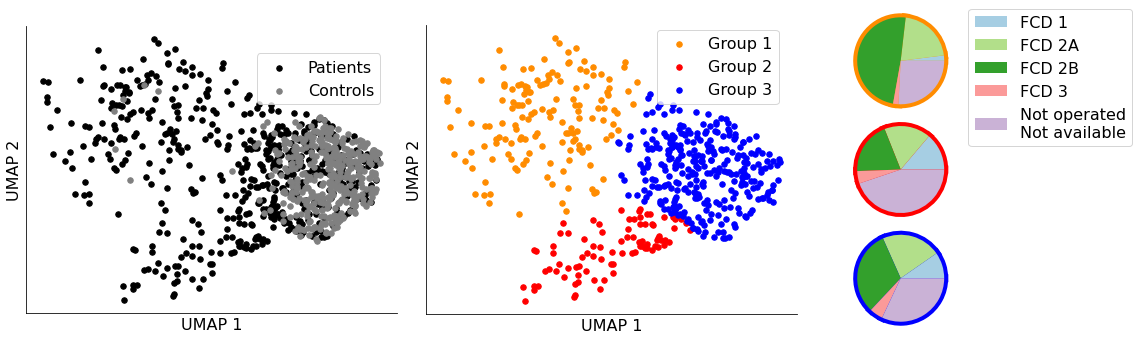

In [83]:
#first figure is actual lesions
from matplotlib.gridspec import GridSpec
import matplotlib
matplotlib.rcParams.update({'font.size': 16})

#display clustering manual mask 
fig = plt.figure(figsize=(17,6))
gs1 = GridSpec(3, 3, width_ratios=[10, 10,4], height_ratios=[ 1,1,1],
             wspace=0.1,hspace=0)
ax1 = fig.add_subplot(gs1[:, 1])
# ax7 = fig.add_subplot(gs1[0, 2])
# ax8 = fig.add_subplot(gs1[1, 2])

# ax9 = fig.add_subplot(gs1[2, 2])

ax2 = fig.add_subplot(gs1[0, 2])

ax3 = fig.add_subplot(gs1[1, 2])

ax4 = fig.add_subplot(gs1[2, 2])

#ax5 = fig.add_subplot(gs1[3, 1])

ax6= fig.add_subplot(gs1[:, 0])


mscatter(clusterable_embedding[lesions_p, 0][c[lesions_p]=='darkorange'], 
         clusterable_embedding[lesions_p, 1][c[lesions_p]=='darkorange'], color='darkorange', s=30,
        ax=ax1,
        label='Group 1')

mscatter(clusterable_embedding[lesions_p, 0][c[lesions_p]=='red'], 
         clusterable_embedding[lesions_p, 1][c[lesions_p]=='red'], color='red', s=30,
        ax=ax1,
        label='Group 2')


mscatter(clusterable_embedding[lesions_p, 0][c[lesions_p]=='blue'], 
         clusterable_embedding[lesions_p, 1][c[lesions_p]=='blue'], color='blue', s=30,
        ax=ax1,
        label='Group 3')


ax1.legend(bbox_to_anchor=[0.6,0.7])
ax1.set_aspect(1)
# x= np.mean(clusterable_embedding[lesions_p, 0][c[lesions_p]=='darkorange'])
# y= np.mean(clusterable_embedding[lesions_p, 1][c[lesions_p]=='darkorange'])
# s=str(np.round(mean_detected[1]*100,1))+'%\ndetected'
# ax1.text(x,y,s,bbox=dict(facecolor='darkorange', alpha=0.5))
# x= np.mean(clusterable_embedding[lesions_p, 0][c[lesions_p]=='blue'])
# y= np.mean(clusterable_embedding[lesions_p, 1][c[lesions_p]=='blue'])+3
# s=str(np.round(mean_detected[0]*100,1))+'%\ndetected'
# ax1.text(x,y,s,bbox=dict(facecolor='blue', alpha=0.5))
# x= np.mean(clusterable_embedding[lesions_p, 0][c[lesions_p]=='red'])
# y= np.mean(clusterable_embedding[lesions_p, 1][c[lesions_p]=='red'])
# s=str(np.round(mean_detected[2]*100,1))+'%\ndetected'
# ax1.text(x,y,s,bbox=dict(facecolor='red', alpha=0.5))
# Hide the right and top spines
format_umap_axes(ax1)
#ax1.set_title('Patient clusters');



histo=subdf.groupby(['g_cluster','FCD_type']).count().values[5:][:,0].reshape(3,5)
palette=np.array(sns.color_palette("Paired"))
color_indices = np.array([0,2,3,4,8])


colors = palette[color_indices]
wedgeprops={"edgecolor":'darkorange','linewidth': 8,  'antialiased': True}

ax2.pie((histo.T/histo.sum(axis=1))[:,1],colors=colors,
                    wedgeprops=wedgeprops);
patches,text=ax2.pie((histo.T/histo.sum(axis=1))[:,1],colors=colors,
                    );
ax2.legend(patches,np.unique(subdf['FCD_type']),bbox_to_anchor=[1.05,1.05])

wedgeprops={"edgecolor":'blue','linewidth': 8,  'antialiased': True}

ax4.pie((histo.T/histo.sum(axis=1))[:,0],colors=colors,
                    
                    wedgeprops=wedgeprops);
ax4.pie((histo.T/histo.sum(axis=1))[:,0],colors=colors,
                    
                    );
wedgeprops={"edgecolor":'red','linewidth': 8,  'antialiased': True}

ax3.pie((histo.T/histo.sum(axis=1))[:,2],colors=colors,
       wedgeprops=wedgeprops)
ax3.pie((histo.T/histo.sum(axis=1))[:,2],colors=colors
    
       )

wedgeprops={"edgecolor":'darkorange','linewidth': 8,  'antialiased': True}
colors = ['k','white']
# patches,text=ax7.pie([seizure_freedom[1.0]],colors=colors,
#                     );
# ax7.pie([seizure_freedom[1.0],1-seizure_freedom[1.0]],colors=colors,
#                     wedgeprops=wedgeprops);
# ax7.pie([seizure_freedom[1.0],1-seizure_freedom[1.0]],colors=colors,
#                     );

# ax2.legend(patches,['Seizure\nfree'],bbox_to_anchor=[1.05,1])

# wedgeprops={"edgecolor":'blue','linewidth': 8,  'antialiased': True}

# ax8.pie([seizure_freedom[2.0],1-seizure_freedom[2.0]],colors=colors,
#                     wedgeprops=wedgeprops);
# ax8.pie([seizure_freedom[2.0],1-seizure_freedom[2.0]],colors=colors,
                    
#                     );
# wedgeprops={"edgecolor":'red','linewidth': 8,  'antialiased': True}

# ax9.pie([seizure_freedom[0.0],1-seizure_freedom[0.0]],colors=colors,
#        wedgeprops=wedgeprops)
# ax9.pie([seizure_freedom[0.0],1-seizure_freedom[0.0]],colors=colors,
#        )

# ax2.pie([mean_detected[0],1-mean_detected[0]],colors=[pal[0],'white'],
#            startangle=90);
# ax2.set_title('Detected')
# ax3.pie([mean_detected[1],1-mean_detected[1]],colors=[pal[1],'white'],
#            startangle=90);
# ax4.pie([mean_detected[2],1-mean_detected[2]],colors=[pal[2],'white'],
#            startangle=90);

# ax5.pie([mean_detected[3],1-mean_detected[3]],colors=[pal[3],'white'],
#            startangle=90);

mscatter(clusterable_embedding[lesions_p, 0], 
         clusterable_embedding[lesions_p, 1], ax=ax6,color='k', s=30,label='Patients')
        #m=markers[lesions_p])

mscatter(clusterable_embedding[lesions_c, 0], 
         clusterable_embedding[lesions_c, 1],ax=ax6, color='grey', s=30,
         label='Controls'
        )
ax6.set_aspect(1)
ax6.legend(bbox_to_anchor=[0.6,0.7])
format_umap_axes(ax6)
plt.tight_layout()
#ax6.set_title('Patients and control features')

fig.savefig('umaps.pdf')
fig.savefig('umaps.png')
#add mini pie chart with detection rates

In [134]:
ages=[]
lobes=[]
bina = np.zeros(sum(lesions_p),dtype=bool)
for i,ID in enumerate(subdf.ID[lesions_p]):
    ages.append(demographics['Age at preoperative'][demographics.ID==ID].values[0])
    lobes.append(l.index(demographics['Lobe'][demographics.ID==ID].values))
    bina[i] = ((df.FCD_type=='FCD 2B')[ df.ID==ID].values).any()
ages = np.array(ages)
lobes=np.array(lobes)

In [135]:
ages = np.log(ages)
ages = (ages-np.nanmin(ages))/(np.nanmax(ages)-np.nanmin(ages))
lobes = (lobes-np.nanmin(lobes))/(np.nanmax(lobes)-np.nanmin(lobes))

In [129]:
l

['temporal', nan, 'occipital', 'frontal', 'parietal']

In [102]:
cmap=plt.cm.turbo
c_ages = cmap(ages)
c_lobes=cmap(lobes)

<AxesSubplot:>

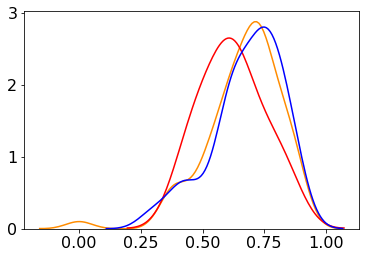

In [143]:
sns.kdeplot(ages[np.logical_and(c[lesions_p]=='darkorange',bina)],color='darkorange')
sns.kdeplot(ages[np.logical_and(c[lesions_p]=='red',bina)],color='red')
sns.kdeplot(ages[np.logical_and(c[lesions_p]=='blue',bina)],color='blue')


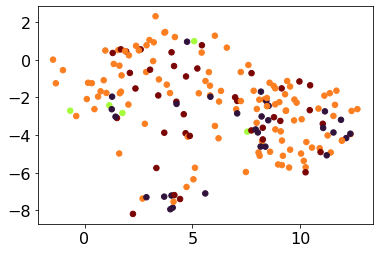

In [144]:
#replot with age and lobe
mscatter(clusterable_embedding[lesions_p, 0][bina], 
         clusterable_embedding[lesions_p, 1][bina], color=c_lobes[bina], s=30,label='Patients')


In [96]:
# histo=subdf.groupby(['g_cluster','FCD_type']).count().values[5:][:,0].reshape(3,5)
# fig,axes=plt.subplots(1,3)
# palette=np.array(sns.color_palette("Paired"))
# color_indices = np.array([0,2,3,4,6])


# colors = palette[color_indices]
# axes[0].pie((histo.T/histo.sum(axis=1))[:,0],colors=colors);
# axes[1].pie((histo.T/histo.sum(axis=1))[:,1],colors=colors);
# axes[2].pie((histo.T/histo.sum(axis=1))[:,2],colors=colors);


.inter_z.intra_z.combat.on_lh.w-g.pct.sm10.mgh
.inter_z.intra_z.combat.on_lh.wm_FLAIR_1.sm10.mgh


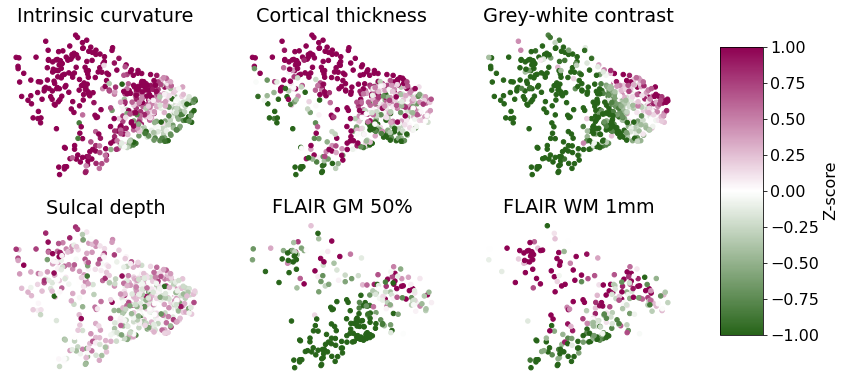

In [150]:




# plot manual mask colored by histopathology
# plt.figure(2)
# pal_2={'control':'#2ff51d','FCD_1':'#85b2d1', 'FCD_2A':'#b2d185','FCD_2B':'#d1a485',  'FCD_3':'#a485d1', 'NaN':'grey', }
# c = np.array([pal_2[x] for x in df['FCD_type']])
# mscatter(clusterable_embedding[lesions_p, 0], clusterable_embedding[lesions_p, 1], color=c[lesions_p], s=15)

# # analyse clusters histo
# print(subdf.groupby(['out_class']).size())
# print(subdf.groupby(['out_class','FCD_type']).size())
import matplotlib
cmap_hex = matplotlib.colors.LinearSegmentedColormap.from_list('grpr',colors=['#276419','#FFFFFF','#8E0152',])

#plot features distribution
fig = plt.figure(figsize=(12,10))
gs1 = gridspec.GridSpec(3,3)
axs = []
             
for i, key in enumerate(keys): 
    overlay = X[lesions_p,i]
    title=titles[key]
    axs.append(fig.add_subplot(gs1[i]))
    if 'FLAIR' in title:
        mask=overlay!=0
        s= mscatter(clusterable_embedding[lesions_p, 0][mask],
                    clusterable_embedding[lesions_p, 1][mask], c=overlay[mask],
                    cmap=cmap_hex, 
                ax=axs[i], s=20, vmin=-1, vmax=1)
    else:
        s= mscatter(clusterable_embedding[lesions_p, 0], clusterable_embedding[lesions_p, 1],
                    c=overlay, cmap=cmap_hex, 
                ax=axs[i], s=20, vmin=-1, vmax=1)
    
    axs[i].set_title(title)
    axs[i].set_aspect(1)
    axs[i].set_axis_off()
    if 'w' in key:
        print(key)
        #fig.colorbar(s,ax=axs[i])
        
cax = fig.add_axes([0.95, 0.45, 0.05, 0.4])
fig.colorbar(s,cax=cax,label='Z-score')

fig.savefig('feature_umaps.pdf',bbox_inches='tight')
fig.savefig('feature_umaps.png',bbox_inches='tight')


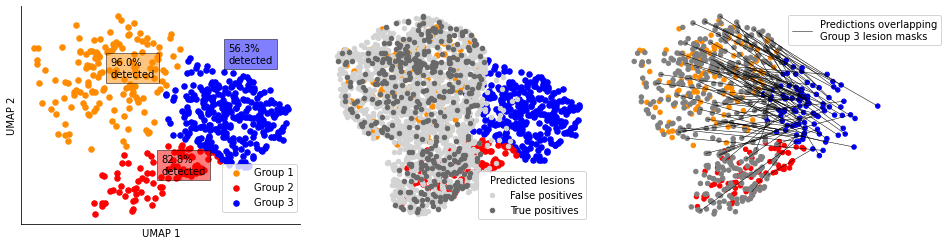

In [142]:
import matplotlib
matplotlib.rcParams.update({'font.size': 10})

fig = plt.figure(figsize=(16,4))
gs1 = GridSpec(1, 3, width_ratios=[10, 10,10], height_ratios=[ 1],
             wspace=0,hspace=0)


ax1 = fig.add_subplot(gs1[0, 0])

ax2 = fig.add_subplot(gs1[0, 1])
ax3 = fig.add_subplot(gs1[0, 2])

mscatter(clusterable_embedding[lesions_p, 0][c[lesions_p]=='darkorange'], 
         clusterable_embedding[lesions_p, 1][c[lesions_p]=='darkorange'], color='darkorange', s=30,
        ax=ax1,
        label='Group 1')






mscatter(clusterable_embedding[lesions_p, 0][c[lesions_p]=='red'], 
         clusterable_embedding[lesions_p, 1][c[lesions_p]=='red'], color='red', s=30,
        ax=ax1,
        label='Group 2')

mscatter(clusterable_embedding[lesions_p, 0][c[lesions_p]=='blue'], 
         clusterable_embedding[lesions_p, 1][c[lesions_p]=='blue'], color='blue', s=30,
        ax=ax1,
        label='Group 3')

ax1.legend(bbox_to_anchor = [0.7,0.3])
ax1.set_aspect(1)
x= np.mean(clusterable_embedding[lesions_p, 0][c[lesions_p]=='darkorange'])
y= np.mean(clusterable_embedding[lesions_p, 1][c[lesions_p]=='darkorange'])
s=str(np.round(mean_detected[1]*100,1))+'%\ndetected'
ax1.text(x,y,s,bbox=dict(facecolor='darkorange', alpha=0.5))
x= np.mean(clusterable_embedding[lesions_p, 0][c[lesions_p]=='blue'])
y= np.mean(clusterable_embedding[lesions_p, 1][c[lesions_p]=='blue'])+3
s=str(np.round(mean_detected[0]*100,1))+'%\ndetected'
ax1.text(x,y,s,bbox=dict(facecolor='blue', alpha=0.5))
x= np.mean(clusterable_embedding[lesions_p, 0][c[lesions_p]=='red'])
y= np.mean(clusterable_embedding[lesions_p, 1][c[lesions_p]=='red'])
s=str(np.round(mean_detected[2]*100,1))+'%\ndetected'
ax1.text(x,y,s,bbox=dict(facecolor='red', alpha=0.5))
#Hide the right and top spines
format_umap_axes(ax1)


colors=np.array(['_','blue','darkorange','red'])
labels=np.zeros(len(X[:,0]))
labels[clusters]=model.predict(clusterable_embedding[clusters])+1
subdf['cluster_class']=labels.astype(int)

mscatter(clusterable_embedding[lesions_p, 0][c[lesions_p]=='darkorange'], 
         clusterable_embedding[lesions_p, 1][c[lesions_p]=='darkorange'], color='darkorange', s=30,
        ax=ax2,
        )




mscatter(clusterable_embedding[lesions_p, 0][c[lesions_p]=='blue'], 
         clusterable_embedding[lesions_p, 1][c[lesions_p]=='blue'], color='blue', s=30,
        ax=ax2,
   )

mscatter(clusterable_embedding[lesions_p, 0][c[lesions_p]=='red'], 
         clusterable_embedding[lesions_p, 1][c[lesions_p]=='red'], color='red', s=30,
        ax=ax2,
        )

detected_cluster=np.logical_and(subdf['type_mask']=='cluster',subdf['detected']==1)

mscatter(clusterable_embedding[clusters, 0], clusterable_embedding[clusters, 1],
                    c='lightgrey',  ax=ax2,
                 s=20, label='False positives')
mscatter(clusterable_embedding[detected_cluster, 0], clusterable_embedding[detected_cluster, 1],
                    c='dimgrey',  ax=ax2,
                 s=20, label='True positives')



ax2.axis('off');
ax2.set_aspect(1)
ax2.legend(title='Predicted lesions',)

#connecting

mscatter(clusterable_embedding[np.logical_and(subdf['detected']==1,lesions_p),0], 
         clusterable_embedding[np.logical_and(subdf['detected']==1,lesions_p),1],
         color=c[np.logical_and(subdf['detected']==1,lesions_p)],ax=ax3
        )

mscatter(clusterable_embedding[detected_cluster, 0], 
         clusterable_embedding[detected_cluster, 1], color=c[detected_cluster],ax=ax3)

clusters_detected = subdf[detected_cluster]
masks_detected = subdf[np.logical_and(np.logical_and(subdf['detected']==1,
                                                     lesions_p),
                                      subdf['out_class']==0)]
for subject in masks_detected.ID:
    a1=clusters_detected[clusters_detected.ID==subject].index[0]
    a2=masks_detected[masks_detected.ID==subject].index
    a_=np.hstack([a1,a2])
    ax3.plot(clusterable_embedding[a_,0],clusterable_embedding[a_,1],'k-', linewidth=0.5,
            )
ax3.plot(clusterable_embedding[a_,0],clusterable_embedding[a_,1],'k-', linewidth=0.5,
            label='Predictions overlapping\nGroup 3 lesion masks')
ax3.legend( bbox_to_anchor = [0.6,0.8]);
ax3.set_aspect(1)
ax3.axis('off');
fig.savefig('predicted_umaps.pdf')
fig.savefig('predicted_umaps.png')

In [143]:
# Load up saliencies for true positives



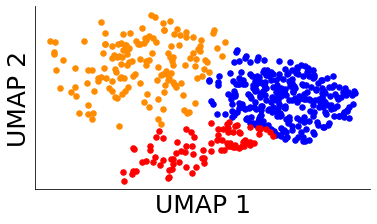

In [144]:
#FOR FIG 1
import matplotlib
import matplotlib
matplotlib.rcParams.update({'font.size': 25})
fig, ax1 = plt.subplots(1,1)
mscatter(clusterable_embedding[lesions_p, 0][c[lesions_p]=='darkorange'], 
         clusterable_embedding[lesions_p, 1][c[lesions_p]=='darkorange'], color='darkorange', s=30,
        ax=ax1,
        label='Cluster 1')




mscatter(clusterable_embedding[lesions_p, 0][c[lesions_p]=='blue'], 
         clusterable_embedding[lesions_p, 1][c[lesions_p]=='blue'], color='blue', s=30,
        ax=ax1,
        label='Cluster 2')

mscatter(clusterable_embedding[lesions_p, 0][c[lesions_p]=='red'], 
         clusterable_embedding[lesions_p, 1][c[lesions_p]=='red'], color='red', s=30,
        ax=ax1,
        label='Cluster 3')
#ax1.legend()
ax1.set_aspect(0.7)
format_umap_axes(ax1)
fig.savefig('fig1_umap.pdf')

In [145]:
subdf.groupby(['g_cluster','FCD_type']).count()


ID  group  hemi  cluster_i  \
g_cluster FCD_type                                                    
-1        FCD 1                         117    117   117        117   
          FCD 2A                        299    299   299        299   
          FCD 2B                        511    511   511        511   
          FCD 3                          64     64    64         64   
          Not operated\nNot available  1237   1237  1237       1237   
 0        FCD 1                          29     29    29         29   
          FCD 2A                         66     66    66         66   
          FCD 2B                         94     94    94         94   
          FCD 3                          15     15    15         15   
          Not operated\nNot available    96     96    96         96   
 1        FCD 1                           3      3     3          3   
          FCD 2A                         32     32    32         32   
          FCD 2B                         74     74    74         74   
          FCD 3                           3      3     3          3   
          Not operated\nNot available    39     39    39         39   
 2        FCD 1                          12     12    12         12   
          FCD 2A                         15     15    15         15   
          FCD 2B                         17     17    17         17   
          FCD 3                           4      4     4          4   
          Not operated\nNot available    39     39    39         39   

                                       type_mask  detected  size_detect  size  \
g_cluster FCD_type                                                              
-1        FCD 1                              117       117          117   117   
          FCD 2A                             299       299          299   299   
          FCD 2B                             511       511          511   511   
          FCD 3                               64        64           64    64   
          Not operated\nNot available       1237      1237         1237  1237   
 0        FCD 1                               29        29           29    29   
          FCD 2A                              66        66           66    66   
          FCD 2B                              94        94           94    94   
          FCD 3                               15        15           15    15   
          Not operated\nNot available         96        96           96    96   
 1        FCD 1                                3         3            3     3   
          FCD 2A                              32        32           32    32   
          FCD 2B                              74        74           74    74   
          FCD 3                                3         3            3     3   
          Not operated\nNot available         39        39           39    39   
 2        FCD 1                               12        12           12    12   
          FCD 2A                              15        15           15    15   
          FCD 2B                              17        17           17    17   
          FCD 3                                4         4            4     4   
          Not operated\nNot available         39        39           39    39   

                                       prediction  FLAIR  ...  \
g_cluster FCD_type                                        ...   
-1        FCD 1                               117    117  ...   
          FCD 2A                              299    299  ...   
          FCD 2B                              511    511  ...   
          FCD 3                                64     64  ...   
          Not operated\nNot available        1237   1237  ...   
 0        FCD 1                                29     29  ...   
          FCD 2A                               66     66  ...   
          FCD 2B                               94     94  ...   
          FCD 3                              

In [148]:
histo

array([[29, 66, 94, 15, 96],
       [ 3, 32, 74,  3, 39],
       [12, 15, 17,  4, 39]])

In [146]:
histo_cluster_df = pd.DataFrame(histo,columns=['FCD_1','FCD_2','FCD_3','None'])

ValueError: Shape of passed values is (3, 5), indices imply (3, 4)

In [147]:
histo_cluster_df = pd.DataFrame(histo.T,columns=[0,1,2])
histo_cluster_df.index=['FCD_1','FCD_2','FCD_3','None']
histo_cluster_df

ValueError: Length mismatch: Expected axis has 5 elements, new values have 4 elements

In [ ]:
from scipy.stats import chi2_contingency
contingency_table = histo
chi2_contingency(contingency_table)

from itertools import combinations

# gathering all combinations for post-hoc chi2
all_combinations = list(combinations(histo_cluster_df.index, 2))
p_vals = []
for comb in all_combinations:
    # subset df into a dataframe containing only the pair "comb"
    new_df = histo_cluster_df[(histo_cluster_df.index == comb[0]) | (histo_cluster_df.index == comb[1])]
    # running chi2 test
    chi2, p, dof, ex = chi2_contingency(new_df, correction=True)
    p_vals.append(p)

In [ ]:
from statsmodels.sandbox.stats.multicomp import multipletests

reject_list, corrected_p_vals = multipletests(p_vals, method='fdr_bh')[:2]
print("original p-value\tcorrected p-value\treject?")
for p_val, corr_p_val, reject in zip(p_vals, corrected_p_vals, reject_list):
    print(p_val, "\t", corr_p_val, "\t", reject)

In [74]:
all_combinations

[('FCD_1', 'FCD_2'),
 ('FCD_1', 'FCD_3'),
 ('FCD_1', 'None'),
 ('FCD_2', 'FCD_3'),
 ('FCD_2', 'None'),
 ('FCD_3', 'None')]

AttributeError: 'list' object has no attribute 'sum'

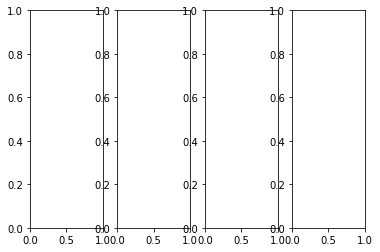

In [49]:
fig,axes=plt.subplots(1,4)
axes[0].pie((histo/histo.sum(axis=0))[:,0])
axes[1].pie((histo/histo.sum(axis=0))[:,1])
axes[2].pie((histo/histo.sum(axis=0))[:,2])
axes[3].pie((histo/histo.sum(axis=0))[:,3])

In [76]:
vals=list(set(df['FCD_type']))
fcd_types=[]
for t in df['FCD_type']:
    fcd_types.append(vals.index(t))
fcd_types=np.array(fcd_types)
#subdf['FCD_type']=fcd_types

In [77]:
pal = sns.color_palette()
cols = []
for  p in np.arange(5):
    cols.append(pal[p])
cols=np.array(cols)

In [40]:
detected_cluster=np.logical_and(subdf['type_mask']=='cluster',subdf['detected']==1)

mscatter(clusterable_embedding[detected_cluster, 0], 
         clusterable_embedding[detected_cluster, 1], 
         color=cols[fcd_types[detected_cluster]], s=30,
        )

NameError: name 'cols' is not defined

In [41]:
subdf['detected_cluster'] = detected_cluster
subdf[detected_cluster].groupby('FCD_type').count()

,ID,group,hemi,cluster_i,type_mask,detected,size_detect,size,prediction,FLAIR,...,.inter_z.intra_z.combat.on_lh.wm_FLAIR_1.sm10.mgh,x,y,z,.on_lh.boundary_zone.mgh,sf,out_class,g_cluster,cluster_class,detected_cluster
FCD_type,,,,,,,,,,,,,,,,,,,,,
FCD_1,21,21,21,21,21,21,21,21,21,21,...,18,21,21,21,6,11,21,21,21,21
FCD_2A,82,82,82,82,82,82,82,82,82,82,...,38,82,82,82,35,51,82,82,82,82
FCD_2B,145,145,145,145,145,145,145,145,145,145,...,59,145,145,145,75,113,145,145,145,145
FCD_3,12,12,12,12,12,12,12,12,12,12,...,9,12,12,12,5,7,12,12,12,12
None,132,132,132,132,132,132,132,132,132,132,...,74,132,132,132,58,5,132,132,132,132


In [42]:
# Plot manual mask+ controls
# fig, ax = plt.subplots()
# #markers=np.array(['.' if x==0 else 'v' if x==2 else '+' for x in subdf['detected']])

# mscatter(clusterable_embedding[lesions_p, 0], 
#          clusterable_embedding[lesions_p, 1], ax=ax,color='k', s=15,)
#         #m=markers[lesions_p])

# mscatter(clusterable_embedding[lesions_c, 0], 
#          clusterable_embedding[lesions_c, 1],ax=ax, color=c[lesions_c], s=15,
         
#         )


#ADD markers for detected not detected
#Add histopathology
# np.min(clusterable_embedding[:,0]),np.max(clusterable_embedding[:,0]),
# np.min(clusterable_embedding[:,1]),np.max(clusterable_embedding[:,1])

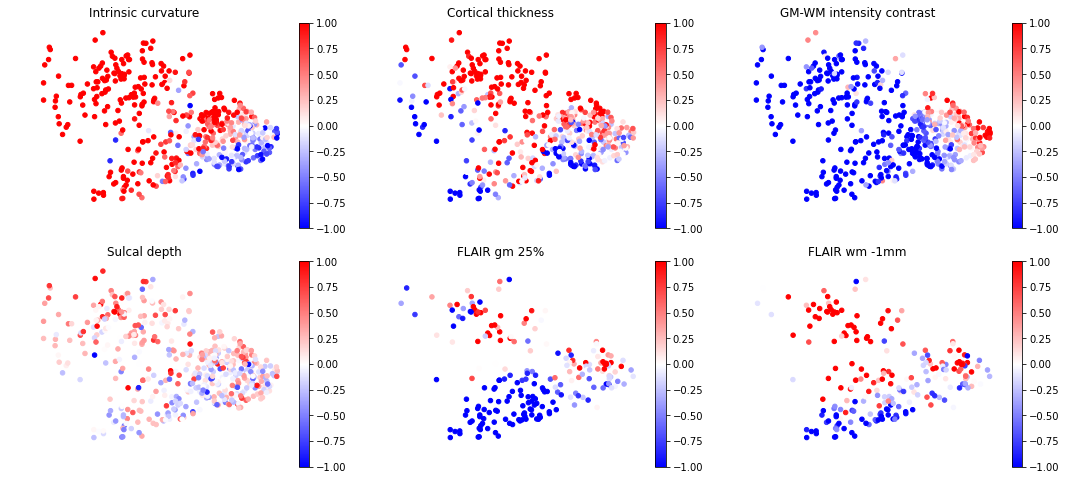

In [43]:




# plot manual mask colored by histopathology
# plt.figure(2)
# pal_2={'control':'#2ff51d','FCD_1':'#85b2d1', 'FCD_2A':'#b2d185','FCD_2B':'#d1a485',  'FCD_3':'#a485d1', 'NaN':'grey', }
# c = np.array([pal_2[x] for x in df['FCD_type']])
# mscatter(clusterable_embedding[lesions_p, 0], clusterable_embedding[lesions_p, 1], color=c[lesions_p], s=15)

# # analyse clusters histo
# print(subdf.groupby(['out_class']).size())
# print(subdf.groupby(['out_class','FCD_type']).size())

#plot features distribution
fig = plt.figure(figsize=(15,10))
gs1 = gridspec.GridSpec(3,3)
axs = []
             
for i, key in enumerate(keys): 
    overlay = X[lesions_p,i]
    title=titles[key]
    axs.append(fig.add_subplot(gs1[i]))
    if 'FLAIR' in title:
        mask=overlay!=0
        s= mscatter(clusterable_embedding[lesions_p, 0][mask],
                    clusterable_embedding[lesions_p, 1][mask], c=overlay[mask],
                    cmap='bwr', 
                ax=axs[i], s=20, vmin=-1, vmax=1)
    else:
        s= mscatter(clusterable_embedding[lesions_p, 0], clusterable_embedding[lesions_p, 1],
                    c=overlay, cmap='bwr', 
                ax=axs[i], s=20, vmin=-1, vmax=1)
    
    axs[i].set_title(title)
    fig.colorbar(s,ax=axs[i])
plt.tight_layout()




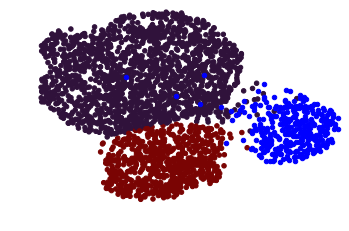

In [44]:
labels=np.zeros(len(X[:,0]))
labels[clusters]=mixture.GaussianMixture(n_components=2,
                            covariance_type='full',
                           random_state=42).fit_predict(clusterable_embedding[clusters])+1
subdf['cluster_class']=labels

mscatter(clusterable_embedding[clusters, 0], clusterable_embedding[clusters, 1],
                    c=subdf['cluster_class'][clusters], cmap='turbo', 
                 s=20, )
mscatter(clusterable_embedding[lesions_c, 0], clusterable_embedding[lesions_c, 1],
                    c='b', cmap='viridis', 
                 s=20, )

a=mixture.GaussianMixture(n_components=3,
                            covariance_type='full',
                           random_state=42).fit(clusterable_embedding[lesions_p])

labels2=np.zeros(len(X[:,0]))
labels2[clusters]=a.predict(clusterable_embedding[clusters])
#add real lesion mask
# clusterable_embedding[lesions] = my_umap.transform(X[lesions])
#labels[clusters] = 111 #predicted clusters 
#labels[lesions_c] = 55 # controls paired lesion mask

# add class to df
subdf['predict_from_manual_clusters']=labels2

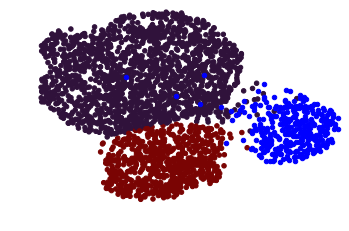

In [45]:
mscatter(clusterable_embedding[clusters, 0], clusterable_embedding[clusters, 1],
                    c=subdf['cluster_class'][clusters], cmap='turbo', 
                 s=20, )
mscatter(clusterable_embedding[lesions_c, 0], clusterable_embedding[lesions_c, 1],
                    c='b', cmap='viridis', 
                 s=20, )

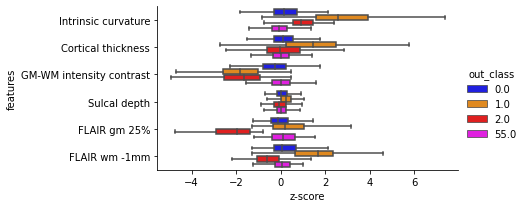

In [46]:
# plot boxplot features
data=subdf[keys].copy()
data['out_class']=subdf['out_class']
data=data[data['out_class']<=55.0]
data_long=data.melt(id_vars='out_class', var_name = 'features', value_name='value')

ort='h'

g = sns.catplot(y='features', x='value', hue = 'out_class',  
                data=data_long, kind='box', palette=pal, orient=ort, legend=True, 
               showfliers=False,
               height=3, aspect=3)
g.set_axis_labels('z-score', "features")
g.set_yticklabels(labels=[titles[key] for key in keys], rotation = 'horizontal')

plt.rcParams.update({'font.size': 12})


In [47]:

def connectpoints(x,y,p1,p2):
    x1, x2 = x[p1], x[p2]
    y1, y2 = y[p1], y[p2]
    plt.plot([x1,x2],[y1,y2],'k-', linewidth=0.5)

    
def get_connection(df, detection=1 ,from_clust=None, reduce=False):
    connects=[]
    for subject in np.unique(df['ID']):
        print(subject)
        subsubdf=df[df['ID']==subject]    
        # get all the lesion from patients
        if from_clust is not None:
            lesion_i = subsubdf.index[(subsubdf['type_mask'] == 'lesion') & (subsubdf['detected'] == detection) & (subsubdf['out_class']==from_clust)].tolist()
        else:
            lesion_i = subsubdf.index[(subsubdf['type_mask'] == 'lesion') & (subsubdf['detected'] == detection)].tolist()
#         print('lesion = \n {} '.format(lesion_i))

        # get all the clusters
        detectClust_i = subsubdf.index[(subsubdf['group'] == 'patient') & (subsubdf['type_mask'] == 'cluster') 
                                       & (subsubdf['detected'] == detection)].tolist()
#         print('clusters = \n {} '.format(detectClust_i))
            
        if reduce==True:
            # connect only the cluster overlapping the most with the lesion
            size_detect = np.array(subsubdf[(subsubdf['group'] == 'patient') & (subsubdf['type_mask'] == 'cluster') 
                                           & (subsubdf['detected'] ==detection)]['size_detect'])
            sort_size=np.argsort(size_detect)[::-1]
            if (lesion_i!=[]) & (detectClust_i!=[]):
                main_cluster = np.array(detectClust_i)[sort_size][0]
                connects.append([lesion_i[0],main_cluster])
        else:  
#         connect all the clusters
            if lesion_i!=[]:
                for i in detectClust_i:
                    connects.append([lesion_i[0],i])
    return connects

In [48]:
subdf

,ID,group,hemi,cluster_i,type_mask,detected,size_detect,size,prediction,FLAIR,...,y,z,.on_lh.boundary_zone.mgh,FCD_type,sf,out_class,g_cluster,cluster_class,detected_cluster,predict_from_manual_clusters
0,MELD_H4_15T_C_0001,control,lh,1,cluster,0,0.0,104,1.000000,True,...,79.693178,27.290104,NaN,None,NaN,111.0,-1,2.0,False,2.0
1,MELD_H4_15T_C_0001,control,lh,666,lesion_pair,1,11676.0,11676,0.000000,True,...,-36.512998,9.577486,NaN,None,NaN,55.0,-1,0.0,False,0.0
2,MELD_H4_15T_C_0001,control,rh,1,cluster,0,0.0,357,1.000000,True,...,70.596646,31.898720,NaN,None,NaN,111.0,-1,2.0,False,2.0
3,MELD_H4_3T_FCD_0005,patient,rh,1,cluster,1,313.0,803,1.000000,True,...,36.102930,-1.065857,NaN,FCD_2B,1.0,111.0,-1,1.0,True,1.0
4,MELD_H4_3T_FCD_0005,patient,rh,2,cluster,0,0.0,314,2.000000,True,...,35.237489,-54.535691,NaN,FCD_2B,1.0,111.0,-1,2.0,False,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3254,MELD_H17_3T_FCD_0027,patient,lh,1,cluster,1,253.0,1522,1.000000,True,...,-7.241827,-6.690683,6.143747,None,NaN,111.0,-1,1.0,True,1.0
3255,MELD_H17_3T_FCD_0027,patient,lh,2,cluster,0,0.0,523,2.000000,True,...,-24.605319,30.265151,156.961334,None,NaN,111.0,-1,1.0,False,1.0
3256,MELD_H17_3T_FCD_0027,patient,lh,3,cluster,0,0.0,202,3.000000,True,...,-15.321415,34.340705,49.023758,None,NaN,111.0,-1,1.0,False,1.0
3257,MELD_H17_3T_FCD_0027,patient,lh,4,cluster,0,0.0,116,4.000000,True,...,-56.502024,41.813199,87.763161,None,NaN,111.0,-1,1.0,False,1.0


In [49]:
connects = get_connection(subdf, detection=1 , from_clust=1, reduce=True)


MELD2_H7_3T_FCD_001
MELD2_H7_3T_FCD_003
MELD2_H7_3T_FCD_004
MELD2_H7_3T_FCD_005
MELD2_H7_3T_FCD_007
MELD2_H7_3T_FCD_008
MELD2_H7_3T_FCD_009
MELD2_H7_3T_FCD_010
MELD2_H7_3T_FCD_012
MELD2_H7_3T_FCD_013
MELD_H10_3T_C_0002
MELD_H10_3T_C_0003
MELD_H10_3T_C_0004
MELD_H10_3T_C_0005
MELD_H10_3T_C_0006
MELD_H10_3T_C_0007
MELD_H10_3T_C_0008
MELD_H10_3T_C_0009
MELD_H10_3T_C_0010
MELD_H10_3T_C_0011
MELD_H10_3T_C_0012
MELD_H10_3T_C_0013
MELD_H10_3T_C_0014
MELD_H10_3T_C_0015
MELD_H10_3T_C_0016
MELD_H10_3T_C_0017
MELD_H10_3T_C_0018
MELD_H10_3T_C_0019
MELD_H10_3T_C_0020
MELD_H10_3T_C_0021
MELD_H10_3T_C_0022
MELD_H10_3T_C_0023
MELD_H10_3T_C_0024
MELD_H10_3T_C_0025
MELD_H10_3T_C_0026
MELD_H10_3T_C_0027
MELD_H10_3T_C_0028
MELD_H10_3T_C_0029
MELD_H10_3T_C_0030
MELD_H10_3T_C_0031
MELD_H10_3T_C_0032
MELD_H10_3T_FCD_0001
MELD_H10_3T_FCD_0002
MELD_H10_3T_FCD_0003
MELD_H10_3T_FCD_0005
MELD_H10_3T_FCD_0006
MELD_H10_3T_FCD_0007
MELD_H10_3T_FCD_0009
MELD_H10_3T_FCD_0010
MELD_H10_3T_FCD_0011
MELD_H10_3T_FCD_0013
M

MELD_H2_3T_FCD_0018
MELD_H3_3T_C_0001
MELD_H3_3T_C_0002
MELD_H3_3T_C_0003
MELD_H3_3T_C_0004
MELD_H3_3T_C_0005
MELD_H3_3T_C_0006
MELD_H3_3T_C_0008
MELD_H3_3T_C_0009
MELD_H3_3T_C_0010
MELD_H3_3T_C_0011
MELD_H3_3T_C_0012
MELD_H3_3T_C_0013
MELD_H3_3T_C_0014
MELD_H3_3T_C_0015
MELD_H3_3T_C_0016
MELD_H3_3T_C_0017
MELD_H3_3T_C_0018
MELD_H3_3T_C_0019
MELD_H3_3T_C_0020
MELD_H3_3T_C_0021
MELD_H3_3T_C_0022
MELD_H3_3T_C_0023
MELD_H3_3T_C_0024
MELD_H3_3T_C_0026
MELD_H3_3T_C_0027
MELD_H3_3T_C_0028
MELD_H3_3T_C_0029
MELD_H3_3T_C_0030
MELD_H3_3T_C_0031
MELD_H3_3T_C_0032
MELD_H3_3T_C_0033
MELD_H3_3T_C_0034
MELD_H3_3T_C_0035
MELD_H3_3T_C_0036
MELD_H3_3T_C_0037
MELD_H3_3T_C_0038
MELD_H3_3T_C_0039
MELD_H3_3T_C_0040
MELD_H3_3T_C_0041
MELD_H3_3T_C_0042
MELD_H3_3T_C_0043
MELD_H3_3T_C_0044
MELD_H3_3T_C_0045
MELD_H3_3T_C_0046
MELD_H3_3T_C_0047
MELD_H3_3T_C_0048
MELD_H3_3T_C_0049
MELD_H3_3T_C_0050
MELD_H3_3T_C_0051
MELD_H3_3T_C_0052
MELD_H3_3T_C_0053
MELD_H3_3T_C_0054
MELD_H3_3T_C_0055
MELD_H3_3T_C_0056
MELD_H3_

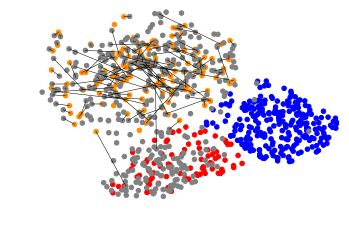

In [50]:
mscatter(clusterable_embedding[lesions_p, 0], 
         clusterable_embedding[lesions_p, 1], color=c[lesions_p],)# m=markers[lesions_p])]
detected_cluster=np.logical_and(subdf['type_mask']=='cluster',subdf['detected']==1)
mscatter(clusterable_embedding[detected_cluster, 0], 
         clusterable_embedding[detected_cluster, 1], color=c[detected_cluster],)# m=markers[clusters], s=10)
for connect in connects:
    connectpoints(clusterable_embedding[:,0],clusterable_embedding[:,1],connect[0],connect[1])


In [126]:
clusters_detected = subdf[detected_cluster]
clusters_detected

,ID,group,hemi,cluster_i,type_mask,detected,size_detect,size,prediction,FLAIR,...,.inter_z.intra_z.combat.on_lh.wm_FLAIR_1.sm10.mgh,x,y,z,.on_lh.boundary_zone.mgh,FCD_type,out_class,g_cluster,cluster_class,predict_from_manual_clusters
3,MELD_H4_3T_FCD_0005,patient,rh,1,cluster,1,313.0,803,1.0,True,...,1.545545,-30.383512,36.102930,-1.065857,NaN,FCD_2B,111.0,-1,1.0,1.0
28,MELD_H3_3T_FCD_0010,patient,rh,1,cluster,1,1205.0,1978,1.0,True,...,3.037613,18.311247,-49.346340,59.598683,NaN,FCD_2B,111.0,-1,1.0,1.0
35,MELD_H4_15T_FCD_0003,patient,lh,1,cluster,1,617.0,3516,1.0,True,...,-1.494832,-9.709192,-39.155547,-48.839844,11.613943,FCD_2B,111.0,-1,2.0,2.0
55,MELD_H4_3T_FCD_0007,patient,rh,1,cluster,1,328.0,335,1.0,True,...,3.232247,-37.353637,16.529320,13.030411,NaN,FCD_2B,111.0,-1,1.0,1.0
87,MELD_H4_15T_FCD_0009,patient,lh,3,cluster,1,158.0,194,3.0,True,...,6.412389,5.643709,-8.640676,66.006535,-0.779796,FCD_2B,111.0,-1,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3210,MELD_H16_3T_FCD_020,patient,rh,1,cluster,1,601.0,657,1.0,True,...,NaN,8.150377,65.355509,-47.213136,NaN,FCD_2B,111.0,-1,1.0,1.0
3212,MELD_H24_3T_FCD_0022,patient,lh,1,cluster,1,102.0,453,1.0,True,...,1.226098,-31.404863,34.156244,4.545249,2.705931,FCD_2A,111.0,-1,2.0,2.0
3223,MELD_H17_3T_FCD_0096,patient,lh,1,cluster,1,321.0,414,1.0,True,...,6.102896,-31.915069,-33.154026,31.324854,-1.713916,NaN,111.0,-1,1.0,1.0
3245,MELD_H23_15T_FCD_0010,patient,lh,2,cluster,1,705.0,1456,2.0,True,...,NaN,3.721214,-75.778915,28.693200,-0.437930,FCD_2A,111.0,-1,1.0,1.0


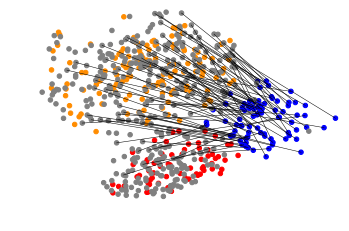

In [51]:
mscatter(clusterable_embedding[np.logical_and(subdf['detected']==1,lesions_p),0], 
         clusterable_embedding[np.logical_and(subdf['detected']==1,lesions_p),1],
         color=c[np.logical_and(subdf['detected']==1,lesions_p)],
        )

mscatter(clusterable_embedding[detected_cluster, 0], 
         clusterable_embedding[detected_cluster, 1], color=c[detected_cluster],)

clusters_detected = subdf[detected_cluster]
masks_detected = subdf[np.logical_and(np.logical_and(subdf['detected']==1,
                                                     lesions_p),
                                      subdf['out_class']==0)]
for subject in masks_detected.ID:
    a1=clusters_detected[clusters_detected.ID==subject].index[0]
    a2=masks_detected[masks_detected.ID==subject].index
    a_=np.hstack([a1,a2])
    plt.plot(clusterable_embedding[a_,0],clusterable_embedding[a_,1],'k-', linewidth=0.5)

In [150]:
subdf['out_class']

0       111.0
1        55.0
2       111.0
3       111.0
4       111.0
        ...  
3254    111.0
3255    111.0
3256    111.0
3257    111.0
3258      1.0
Name: out_class, Length: 3259, dtype: float64

In [152]:
subdf.columns

Index(['ID', 'group', 'hemi', 'cluster_i', 'type_mask', 'detected',
       'size_detect', 'size', 'prediction', 'FLAIR',
       '.combat.on_lh.curv.sm5.mgh', '.combat.on_lh.gm_FLAIR_0.25.sm10.mgh',
       '.combat.on_lh.gm_FLAIR_0.5.sm10.mgh',
       '.combat.on_lh.gm_FLAIR_0.75.sm10.mgh',
       '.combat.on_lh.gm_FLAIR_0.sm10.mgh',
       '.combat.on_lh.pial.K_filtered.sm20.mgh', '.combat.on_lh.sulc.sm5.mgh',
       '.combat.on_lh.thickness.sm10.mgh', '.combat.on_lh.w-g.pct.sm10.mgh',
       '.combat.on_lh.wm_FLAIR_0.5.sm10.mgh',
       '.combat.on_lh.wm_FLAIR_1.sm10.mgh',
       '.inter_z.asym.intra_z.combat.on_lh.curv.sm5.mgh',
       '.inter_z.asym.intra_z.combat.on_lh.gm_FLAIR_0.25.sm10.mgh',
       '.inter_z.asym.intra_z.combat.on_lh.gm_FLAIR_0.5.sm10.mgh',
       '.inter_z.asym.intra_z.combat.on_lh.gm_FLAIR_0.75.sm10.mgh',
       '.inter_z.asym.intra_z.combat.on_lh.gm_FLAIR_0.sm10.mgh',
       '.inter_z.asym.intra_z.combat.on_lh.pial.K_filtered.sm20.mgh',
       '.inter_z.asym.i